In [131]:
import pandas as pd
import numpy as np
import torch as T
from torch import nn
import torch.nn.functional as F

import chemprop
import rdkit

import pickle as pkl
import gzip

from tqdm.notebook import tqdm
import argparse

import random

In [132]:
import covid
from covid.datasets import *
from covid.modules import *
from covid.data import *
from covid.model import *
from covid.schedulers import LinearWarmupScheduler
from covid.reporting import get_performance_plots

from covid.modules.chemistry import MPNEncoder

In [133]:
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display

In [134]:
import covid.training

In [135]:
from hyperopt import Trials

In [140]:
with open("./hyperopt_trials.pkl", 'rb') as f:
    trials = pkl.load(f)

In [136]:
from hyperopt.mongoexp import MongoTrials

In [387]:
mtrials = MongoTrials('mongo://localhost:1234/covid/jobs', exp_key='covid-2')

In [405]:
mtrials.refresh()

In [406]:
len(mtrials.trials)

91

In [407]:
mtrials.losses()

[7.439429350159346,
 0.1692000009115363,
 None,
 0.16114772885089448,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0.22373886773720947,
 0.23310064350091755,
 0.2402137711800636,
 0.21203745794913786,
 0.2274126981031661,
 0.21915882515082888,
 0.19002372246121751,
 0.22345033561588287,
 0.2056929076334187,
 0.28525064332917555,
 0.21655175371417645,
 0.2802831254829167,
 0.3126174179777176,
 0.25632707441524355,
 0.2043305233835873,
 0.23226056074481238,
 0.23385558467193485,
 0.25837453606217403,
 0.20344991294791878,
 0.33895270858506893,
 0.21328111628602275,
 0.22479035340367565,
 0.3556961630207984,
 0.22169327307610345,
 0.22389276772592984,
 0.23422493468952832,
 0.2890324062397457,
 0.2520814773839728,
 0.2715198570780236,
 0.2690689443427018,
 0.2258686390389643,
 0.44775285827415306,
 0.2434224739944544,
 0.31642576905365183,
 0.3342891712872157,
 0.28491476489814715,
 0.2749412064689787,
 0.2956341970039592,
 0.27734930605432073,
 0.354496608268090

In [386]:
mtrials.delete_all()

In [27]:
import json

In [31]:
v_stats = t['result']['validation_stats']

In [33]:
v_x, v_loss, v_acc, v_conf = zip(*v_stats)

In [72]:
from datetime import timedelta
from collections import Iterable, Mapping

In [89]:
def make_json_friendly(result):
    if isinstance(result, list):
        return make_json_list_friendly(result)
    
    if len(result) == 0:
        return result
    
    output = {}
    
    for k,v in result.items():
        if isinstance(v, np.ndarray):
            v = list(v)
        elif isinstance(v, timedelta):
            v = v.total_seconds()
        
        if isinstance(v, Mapping):
            v = make_json_friendly(v)
        elif isinstance(v, Iterable):
            v = make_json_list_friendly(v)
            
        
        output[k] = v
    return output

def make_json_list_friendly(lst):
    if len(lst) == 0 or isinstance(lst, str):
        return lst
    
    output = []
    for item in lst:
        if isinstance(item, np.ndarray):
            item = list(item)
        elif isinstance(item, timedelta):
            item = item.total_seconds()
            
        if isinstance(item, Mapping):
            item = make_json_friendly(item)
        elif isinstance(item, Iterable):
            item = make_json_list_friendly(item)
            
        output.append(item)
    return output

In [143]:
trials.trials[0]['result']['loss']

0.4528115093335509

In [144]:
from scipy.stats import linregress

In [238]:
t = mtrials.trials[-1]

In [240]:
t.keys()

['_id',
 'state',
 'tid',
 'spec',
 'result',
 'misc',
 'exp_key',
 'owner',
 'version',
 'book_time',
 'refresh_time']

In [341]:
all_trials = MongoTrials('mongo://localhost:1234/covid/jobs', exp_key='covid-2')

In [343]:
all_trials.trials

[]

In [346]:
int(np.ceil(int(50/2/1)))

25

In [265]:
mtrials.new_trial_ids(135)

[137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271]

In [349]:
t.keys()

['state',
 'tid',
 'spec',
 'result',
 'misc',
 'exp_key',
 'owner',
 'version',
 'book_time',
 'refresh_time']

In [150]:
for t in trials.trials:
    t['exp_key'] = 'covid-1'
    t['misc']['idxs']['dropout_rate'] = [t['misc']['tid']]
    t['misc']['vals']['dropout_rate'] = [0.4]
    v_x, v_loss, _, _ = zip(*t['result']['validation_stats'])
    slope, intercept, _, _, _ = linregress(v_x[3:6], v_loss[3:6])
    t['result']['loss'] = intercept + slope * 1.5
    mtrials.insert_trial_doc(make_json_friendly(t))

In [162]:
mtrials.refresh()

In [177]:
import importlib

In [178]:
importlib.reload(covid.reporting)

<module 'covid.reporting' from 'C:\\Users\\Bryce.Eakin\\src\\COVID\\covid\\reporting.py'>

In [153]:
from covid.reporting import get_performance_plots

(0.0, 0.5)

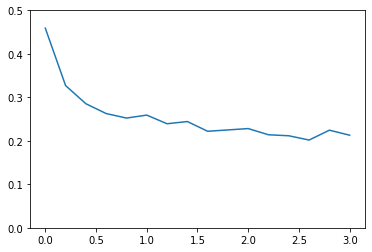

In [175]:
fig, ax = plt.subplots()
ax.plot(v_x, v_loss)
ax.set_ylim((0.0, 0.5))

In [226]:
mtrials.refresh()

In [200]:
sum(1 if x == 'new' else 0 for x in mtrials.statuses())

7

In [184]:
from IPython.display import display, clear_output
from time import sleep



In [197]:
mtrials.trials[0]['exp_key']

'covid-1'

In [229]:
mtrials.refresh()

In [271]:
mtrials.trials[t_idx]['misc']

['tid', 'cmd', 'workdir', 'idxs', 'vals']

In [230]:
def plot_param(pname):

    xs = []
    ys = []

    for t in mtrials.trials:
        if t['result'].get('loss') is None:
            continue
        params = hyperopt.space_eval(search_space, {k:v[0] for k,v in t['misc']['vals'].items()})
        xs.append(params[pname])
        ys.append(t['result']['loss'])

    fig, ax = plt.subplots()
    ax.scatter(xs, ys)
    ax.set_yscale('log')
    ax.set_title(pname)
    
    display(fig)
    plt.close(fig)

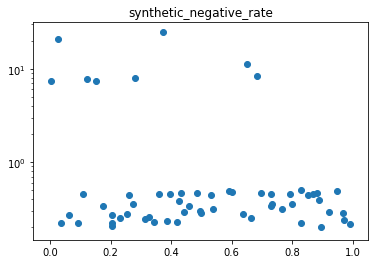

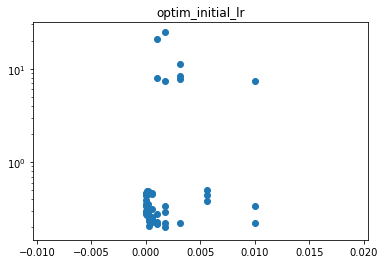

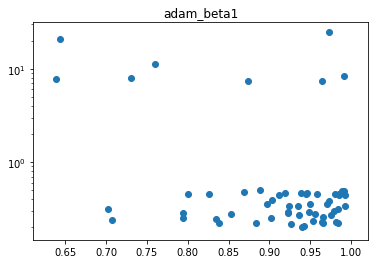

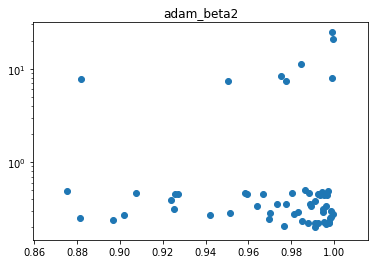

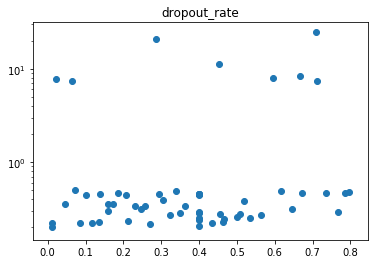

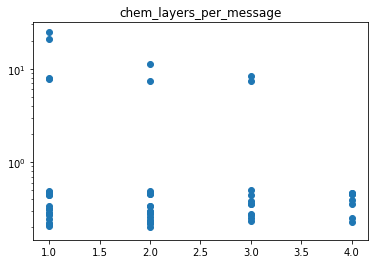

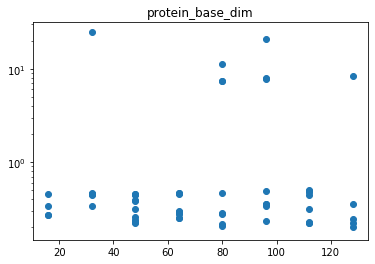

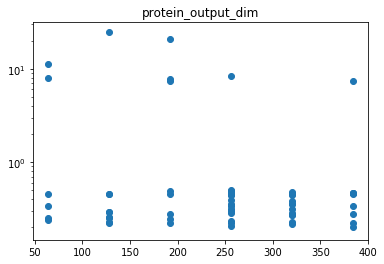

In [231]:
for param in ['synthetic_negative_rate', 'optim_initial_lr', 'adam_beta1', 'adam_beta2', 'dropout_rate', 'chem_layers_per_message', 'protein_base_dim', 'protein_output_dim']:
    plot_param(param)

In [411]:
mtrials.refresh()

In [415]:
mtrials.delete_all()

In [414]:
trials = list(mtrials.trials)

In [417]:
for t in trials:
    del t['_id']
    tid = t['tid']
    t['misc']['idxs'] = {k:[tid] for k in t['misc']['idxs'].keys()}

In [418]:
t['misc']

SON([('tid', 3738), ('cmd', ['domain_attachment', 'FMinIter_Domain']), ('workdir', None), ('idxs', {'chem_hidden_size': [3738], 'chem_layers_per_message': [3738], 'chem_nonlinearity': [3738], 'dropout_rate': [3738], 'eps': [3738], 'inv_beta1': [3738], 'inv_beta2': [3738], 'lr_exp': [3738], 'neg_rate': [3738], 'protein_downscale_nonlinearity': [3738], 'protein_nonlinearity': [3738], 'protein_out_dim': [3738], 'protien_base_dim': [3738]}), ('vals', SON([('chem_hidden_size', [448.0]), ('chem_layers_per_message', [1.0]), ('chem_nonlinearity', [2]), ('dropout_rate', [0.7097555972104654]), ('eps', [0.00015811358302116524]), ('inv_beta1', [0.027406156115387627]), ('inv_beta2', [0.0007945309759339589]), ('lr_exp', [2.75]), ('neg_rate', [0.37168172156026946]), ('protein_downscale_nonlinearity', [4]), ('protein_nonlinearity', [1]), ('protein_out_dim', [128.0]), ('protien_base_dim', [32.0])]))])

In [413]:
mtrials.losses()

[7.439429350159346,
 0.1692000009115363,
 None,
 0.16114772885089448,
 0.165470789611178,
 0.17653787017966338,
 0.22130780178566012,
 0.16525157686275244,
 0.2172142272598822,
 0.18634207285815674,
 None,
 0.16664173639201835,
 0.1957035639003981,
 0.17309890359522506,
 0.22373886773720947,
 0.23310064350091755,
 0.2402137711800636,
 0.21203745794913786,
 0.2274126981031661,
 0.21915882515082888,
 0.19002372246121751,
 0.22345033561588287,
 0.2056929076334187,
 0.28525064332917555,
 0.21655175371417645,
 0.2802831254829167,
 0.3126174179777176,
 0.25632707441524355,
 0.2043305233835873,
 0.23226056074481238,
 0.23385558467193485,
 0.25837453606217403,
 0.20344991294791878,
 0.33895270858506893,
 0.21328111628602275,
 0.22479035340367565,
 0.3556961630207984,
 0.22169327307610345,
 0.22389276772592984,
 0.23422493468952832,
 0.2890324062397457,
 0.2520814773839728,
 0.2715198570780236,
 0.2690689443427018,
 0.2258686390389643,
 0.44775285827415306,
 0.2434224739944544,
 0.3164257690536

0.20344991294791878


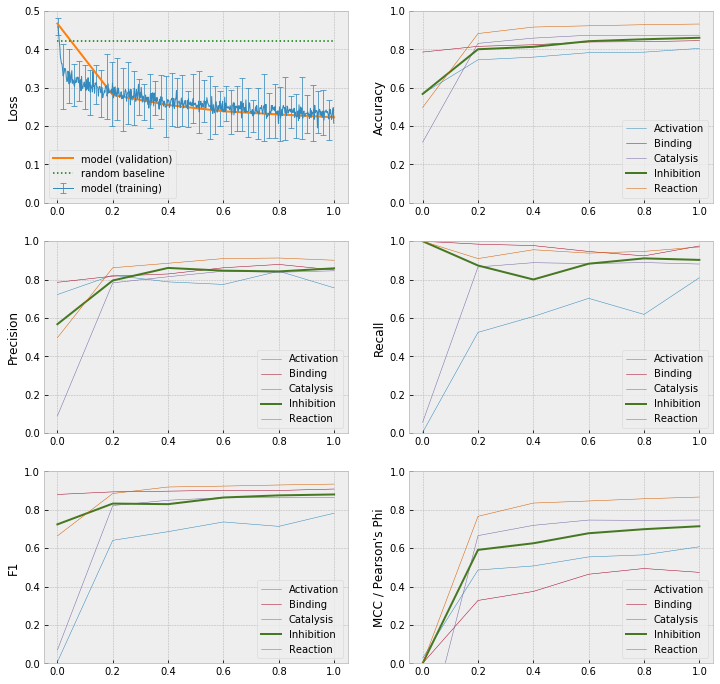

KeyboardInterrupt: 

In [410]:
idx_list = np.argsort([x if x is not None else np.inf for x in mtrials.losses()]).flatten()
last = False

for i, t_idx in enumerate(idx_list):
    t = mtrials.trials[t_idx]
    if t is None or t.get('result') is None or t['result'].get('training_loss_hist') is None:
        t = mtrials.best_trial
        last = True
        
    losses = t['result']['training_loss_hist']
    validation_stats = t['result']['validation_stats']

    fig = get_performance_plots(losses, validation_stats);
    clear_output()
    print(t['result']['loss'])
    display(fig)
    plt.close(fig);
    
    if last:
        break
    sleep(5 if i < 5 else 1)

In [331]:
import requests

In [333]:
with open('./logfile.txt', 'rb') as f:
    requests.put('http://127.0.0.1:8000/training-state/logfile', data=f)

In [334]:
r = requests.get('https://google.com')

In [275]:
import logging

In [322]:
d = mtrials.best_trial['refresh_time']

In [325]:
d.strftime("%S")

'29'

In [317]:
mtrials.best_trial.keys()

['_id',
 'state',
 'tid',
 'spec',
 'result',
 'misc',
 'exp_key',
 'owner',
 'version',
 'book_time',
 'refresh_time']

In [313]:
len(mtrials.trials)

82

In [277]:
log = logging.getLogger()

In [128]:
from hyperopt import hp
import hyperopt
search_space = {
        'synthetic_negative_rate': hp.uniform('neg_rate', 0,1),
        'optim_initial_lr': 10 ** -hp.quniform('lr_exp', 2, 5, 0.25),
        'adam_beta1': 1-hp.loguniform('inv_beta1', -5, -1),
        'adam_beta2': 1-hp.loguniform('inv_beta2', -8, -2),
        'optim_adam_eps': hp.loguniform('eps', -15, 0),
        'dropout_rate': hp.uniform('dropout_rate', 0.01, 0.8),
        'chem_layers_per_message': hp.quniform('chem_layers_per_message', 1,4,1),
        'chem_hidden_size': hp.quniform('chem_hidden_size', 64,384,64),
        'chem_nonlinearity': hp.choice(
            'chem_nonlinearity',
            ['ReLU', 'LeakyReLU', 'tanh', 'ELU']),
        'protein_base_dim': hp.quniform('protien_base_dim', 16,80,16),
        'protein_output_dim': hp.quniform('protein_out_dim', 64, 384, 64),
        'protein_nonlinearity': hp.choice(
            'protein_nonlinearity', 
            ['relu', 'silu', 'tanh', 'leaky_relu', 'elu']),
        'protein_downscale_nonlinearity': hp.choice(
            'protein_downscale_nonlinearity', 
            ['relu', 'silu', 'tanh', 'leaky_relu', 'elu']),
    }

In [129]:
mtrials.best_trial['misc']['vals']

SON([('chem_hidden_size', [384.0]), ('chem_layers_per_message', [1.0]), ('chem_nonlinearity', [3]), ('eps', [1.973891530032813e-06]), ('inv_beta1', [0.05730964741577067]), ('inv_beta2', [0.02348907039091992]), ('lr_exp', [3.5]), ('neg_rate', [0.20401408708284396]), ('protein_downscale_nonlinearity', [4]), ('protein_nonlinearity', [0]), ('protein_out_dim', [256.0]), ('protien_base_dim', [80.0]), ('dropout_rate', [0.4])])

In [301]:
hyperopt.space_eval(search_space, {k:v[0] for k,v in mtrials.trials[idx_list[2]]['misc']['vals'].items() if len(v) > 0})

{'adam_beta1': 0.9610379605240368,
 'adam_beta2': 0.9909243250920076,
 'chem_hidden_size': 448.0,
 'chem_layers_per_message': 1.0,
 'chem_nonlinearity': 'ELU',
 'dropout_rate': 0.03688811278332571,
 'optim_adam_eps': 4.249902669467103e-05,
 'optim_initial_lr': 0.00031622776601683794,
 'protein_base_dim': 32.0,
 'protein_downscale_nonlinearity': 'tanh',
 'protein_nonlinearity': 'relu',
 'protein_output_dim': 64.0,
 'synthetic_negative_rate': 0.13382273239526193}

In [105]:
dict(mtrials.best_trial['misc']['vals'])

{'chem_hidden_size': [384.0],
 'chem_layers_per_message': [1.0],
 'chem_nonlinearity': [3],
 'eps': [1.973891530032813e-06],
 'inv_beta1': [0.05730964741577067],
 'inv_beta2': [0.02348907039091992],
 'lr_exp': [3.5],
 'neg_rate': [0.20401408708284396],
 'protein_downscale_nonlinearity': [4],
 'protein_nonlinearity': [0],
 'protein_out_dim': [256.0],
 'protien_base_dim': [80.0]}

In [5]:
config = covid.training.CovidTrainingConfiguration()
dl, vdl = covid.training._create_dataloaders(config)

In [6]:
len(dl)

8545

In [7]:
it = iter(dl)

In [10]:
for _ in range (8500):
    next(it)

In [4]:
np.random.seed(4);
random.seed(4);
T.manual_seed(4);

# 4 -- chosen by fair die roll.  Guaranteed to be random.  https://xkcd.com/221/

In [5]:
DROPOUT_RATE = 0.4
BATCH_SIZE = 16

VALIDATION_FREQUENCY = 0.2

In [6]:
DEVICE = 'cuda'

In [7]:
chem_model = MPNEncoder(
    layers_per_message=2, 
    hidden_size=300,
    dropout=DROPOUT_RATE
)

protein_model = create_protein_model(dropout=DROPOUT_RATE)

model = CovidModel(chem_model, protein_model, dropout=DROPOUT_RATE)

In [8]:
params = list(model.parameters())

In [17]:
for param in params:
    if len(param.shape) >= 2:
        T.nn.init.kaiming_normal_(param)
    else:
        T.nn.init.normal_(param)

In [8]:
model.to(DEVICE);

In [9]:
if not os.path.exists('./data/training'):
    create_data_split('./data', './data/training', './data/final_holdout')
    
    for i in range(10):
        create_data_split('./data/training', f'./data/train_{i:02}', f'./data/valid_{i:02}')

In [10]:
# Have to reset the seeds again to account for the possibility we did or didn't just create the datasets

np.random.seed(4);
random.seed(4);
T.manual_seed(4);

In [11]:
data = covid.datasets.StitchDataset('./data/train_00')
dataloader = create_dataloader(data, BATCH_SIZE)

In [12]:
validation_data = covid.datasets.StitchDataset('./data/valid_00', neg_rate=0.0)
validation_dataloader = create_dataloader(validation_data, BATCH_SIZE)

In [13]:
optim = T.optim.Adam(model.parameters(), lr=1e-4, betas=(0.95, 0.99))
warmup = LinearWarmupScheduler(optim, 2000)

In [14]:
losses = []
validation_stats = []

In [21]:
with gzip.open('./checkpoints/model_train_fold00_003.pkl.gz', 'rb') as f:
    state = T.load(f)

In [16]:
state['optim']['param_groups'][0]

{'lr': 5.6234132519034975e-05,
 'betas': (0.95, 0.995),
 'eps': 1e-08,
 'weight_decay': 0,
 'amsgrad': False,
 'params': [1287416305048,
  1287416304968,
  1287416304888,
  1287416304328,
  1287416304808,
  1287416571928,
  1287416572008,
  1287416572328,
  1287416572408,
  1287416572568,
  1287416572728,
  1287416572888,
  1287416573048,
  1287416573848,
  1287416627272,
  1287416627432,
  1287416627592,
  1287416627752,
  1287416627912,
  1287416628952,
  1287416629032,
  1287416629192,
  1287416629352,
  1287416629512,
  1287416629672,
  1287416630472,
  1287416630552,
  1287416630712,
  1287416630872,
  1287416631032,
  1287416631192,
  1287416693928,
  1287416694008,
  1287416694728,
  1287416694808,
  1287416694968,
  1287416695128,
  1287416695288,
  1287416695448,
  1287416696248,
  1287416696328,
  1287416696488,
  1287416696648,
  1287416766616,
  1287416766696,
  1287416767816,
  1287416767896,
  1287416768456,
  1287416768536,
  1287416768696,
  1287416768856,
  12874167690

In [22]:
a, b, c, d = zip(*state['validation_stats'])

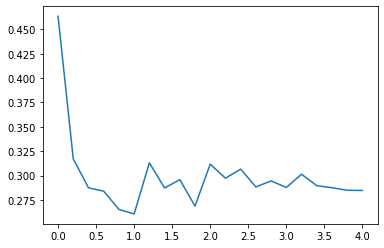

In [24]:
plt.plot(a,b)

In [19]:
b

(0.46351972497999666,
 0.31705334374681116,
 0.2874237253144383,
 0.2839091288484633,
 0.2652374904602766,
 0.26057349471375346,
 0.313025507889688,
 0.2871992769651115,
 0.29574744069948794,
 0.2686461734957993,
 0.3117236337810755)

In [72]:
c

(array([0.5757798 , 0.24077486, 0.3670774 , 0.32965682, 0.28705316]),
 array([0.66705973, 0.7942977 , 0.87277217, 0.79145701, 0.82455177]),
 array([0.67934792, 0.80454201, 0.88669814, 0.79894614, 0.83416545]),
 array([0.80140947, 0.77208418, 0.89145058, 0.82033474, 0.88650104]),
 array([0.84964117, 0.78305617, 0.90101303, 0.82478764, 0.91807779]),
 array([0.84856255, 0.819456  , 0.87960643, 0.83847463, 0.91785839]))

In [74]:
from collections import namedtuple

In [75]:
namedtuple('')

<function collections.namedtuple(typename, field_names, *, rename=False, defaults=None, module=None)>

In [78]:
from collections import namedtuple
ConfusionMatrix = namedtuple('ConfusionMatrix', ['tp', 'fp', 'fn', 'tn'])

In [17]:
from functools import partial

get_validation_loss = partial(
    calculate_average_loss_and_accuracy, 
    model, 
    validation_dataloader,
    DEVICE
)

In [18]:
epoch = 0
last_validation = epoch

if os.path.exists("training_state_00.pkl"):
    state = T.load("./training_state_00.pkl", map_location=DEVICE)
        
    epoch = state.get('epoch', epoch)
    losses = state.get('losses', losses)
    validation_stats = state.get('validation_stats', validation_stats)
    last_validation = state.get('last_validation', last_validation)
    model.load_state_dict(state['model'])
    optim.load_state_dict(state['optim'])
    warmup.load_state_dict(state['warmup'])
    
    
if epoch == 0:
    vloss, vacc, v_conf = get_validation_loss()
    validation_stats.append([0, vloss, vacc, v_conf])

In [19]:
if not os.path.exists("./checkpoints/"):
    os.mkdir("./checkpoints")

In [20]:
chart_area = widgets.Output()
display(chart_area)

for epoch in tqdm(range(epoch, 100)):
    idx = 0
    
    model.train()
    pct_epoch = 0
    
    for batch in tqdm(dataloader, leave=False):

        model.zero_grad()
        _, _, loss, _ = run_model(model, batch, DEVICE)

        loss.backward()

        optim.step()
        warmup.step()
            
        idx += BATCH_SIZE
        pct_epoch = min(1.0, idx/len(data))
        
        losses.append((epoch + pct_epoch, loss.item()))
        
        if pct_epoch == 1.0 or epoch + pct_epoch - last_validation > VALIDATION_FREQUENCY:
            vloss, vacc, v_conf = get_validation_loss()
            validation_stats.append([epoch+pct_epoch, vloss, vacc, v_conf])
            
            chart_area.clear_output()
            fig = get_performance_plots(losses, validation_stats)
            with chart_area:
                display(fig)
            plt.close(fig)
            
            last_validation = epoch + pct_epoch
            
    state = {
        'epoch': epoch,
        'losses': losses,
        'validation_stats': validation_stats,
        'last_validation': last_validation,
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'warmup': warmup.state_dict(),
    }
    T.save(state, f'./checkpoints/model_00_{epoch:03}.pkl')
    T.save(state, "./training_state_00.pkl")

Output()

KeyboardInterrupt: 

In [ ]:
plot_losses(losses, validation_stats, max(10, len(losses)//2000))